### Credit Risk Modeling using Machine Learning

Key Highlights:

- Machine learning in credit risk assessment
- Building predictive credit risk models
- Enhancing decision-making processes with data-driven insights

In [90]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
import warnings
import os

### Data Ingestion


In [91]:
a1 = pd.read_excel('case_study1.xlsx')
a2 = pd.read_excel('case_study2.xlsx')

In [92]:
df1 = a1.copy()
df2 = a2.copy()

### Data Preprocessing and Feature Engineering

In [94]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51336 entries, 0 to 51335
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PROSPECTID            51336 non-null  int64  
 1   Total_TL              51336 non-null  int64  
 2   Tot_Closed_TL         51336 non-null  int64  
 3   Tot_Active_TL         51336 non-null  int64  
 4   Total_TL_opened_L6M   51336 non-null  int64  
 5   Tot_TL_closed_L6M     51336 non-null  int64  
 6   pct_tl_open_L6M       51336 non-null  float64
 7   pct_tl_closed_L6M     51336 non-null  float64
 8   pct_active_tl         51336 non-null  float64
 9   pct_closed_tl         51336 non-null  float64
 10  Total_TL_opened_L12M  51336 non-null  int64  
 11  Tot_TL_closed_L12M    51336 non-null  int64  
 12  pct_tl_open_L12M      51336 non-null  float64
 13  pct_tl_closed_L12M    51336 non-null  float64
 14  Tot_Missed_Pmnt       51336 non-null  int64  
 15  Auto_TL            

#### Dealing with -99999 value

In [95]:
result = df1[df1.eq(-99999).any(axis=1)]

In [96]:
result.shape

(40, 26)

In [97]:
df1 = df1.drop(df1[df1.eq(-99999).any(axis=1)].index)

In [98]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51336 entries, 0 to 51335
Data columns (total 62 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   PROSPECTID                    51336 non-null  int64  
 1   time_since_recent_payment     51336 non-null  int64  
 2   time_since_first_deliquency   51336 non-null  int64  
 3   time_since_recent_deliquency  51336 non-null  int64  
 4   num_times_delinquent          51336 non-null  int64  
 5   max_delinquency_level         51336 non-null  int64  
 6   max_recent_level_of_deliq     51336 non-null  int64  
 7   num_deliq_6mts                51336 non-null  int64  
 8   num_deliq_12mts               51336 non-null  int64  
 9   num_deliq_6_12mts             51336 non-null  int64  
 10  max_deliq_6mts                51336 non-null  int64  
 11  max_deliq_12mts               51336 non-null  int64  
 12  num_times_30p_dpd             51336 non-null  int64  
 13  n

In [99]:
df2.shape

(51336, 62)

In [100]:
columns_to_be_removed = [col for col in df2.columns if (df2[col] == -99999).sum() > 10000]
columns_to_be_removed

['time_since_first_deliquency',
 'time_since_recent_deliquency',
 'max_delinquency_level',
 'max_deliq_6mts',
 'max_deliq_12mts',
 'CC_utilization',
 'PL_utilization',
 'max_unsec_exposure_inPct']

In [101]:
df2 = df2.drop(columns_to_be_removed, axis=1)

In [102]:
df2.shape

(51336, 54)

In [103]:
df2 = df2[(df2 != -99999).all(axis=1)]

In [104]:
df2.shape

(42066, 54)

In [107]:
# Merge the two dataframes, inner join so that no nulls are present
df = pd.merge(df1, df2, how ='inner',
               left_on = ['PROSPECTID'],
               right_on = ['PROSPECTID'])

In [108]:
df.shape

(42064, 79)

In [109]:
 df.isna().sum().sum()

0

In [110]:
categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
print(categorical_columns)

['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2', 'first_prod_enq2', 'Approved_Flag']


#### Hypothesis testing.
#### Inferential statistics.

Are these two associated -- MARITALSTATUS vs Approved_Flag???

1. H0(True): Null Hypothesis
    
2. H1(False): Alternate Hypothesis
    
3. Alpha: significance / strictness level (as usuall 5%)

4. Confidence Interveral: alpha - 1
    
5. P-value: Calculate the evidence against H0

6. If p-value <= alpha
      Rejected H0
   ,else
      Fail to reject H0


NB: Popular technique to calculate p-value: T-test, Chisquare, Anova

- `Chisquare`: categorical vs categorical

- `T-test`: categorical vs numerical
     `NB`: In categorical column unique value is 2.

- `Anova`: categorical vs numerical
    `NB`: In categorical column unique value is (>=3).


#### Chi-square test

In [111]:
# Chi-square test
for i in ['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2', 'first_prod_enq2']:
    chi2, pval, _, _ = chi2_contingency(pd.crosstab(df[i], df['Approved_Flag']))
    print(i, '---', pval)

MARITALSTATUS --- 3.578180861038862e-233
EDUCATION --- 2.6942265249737532e-30
GENDER --- 1.907936100186563e-05
last_prod_enq2 --- 0.0
first_prod_enq2 --- 7.84997610555419e-287


As all the categorical features have p-value <= 0.5 , we will take all columns

In [112]:
numerical_columns = [col for col in df.columns if df[col].dtype != 'object' and col not in ['PROSPECTID','Approved_Flag']]
print(numerical_columns)

['Total_TL', 'Tot_Closed_TL', 'Tot_Active_TL', 'Total_TL_opened_L6M', 'Tot_TL_closed_L6M', 'pct_tl_open_L6M', 'pct_tl_closed_L6M', 'pct_active_tl', 'pct_closed_tl', 'Total_TL_opened_L12M', 'Tot_TL_closed_L12M', 'pct_tl_open_L12M', 'pct_tl_closed_L12M', 'Tot_Missed_Pmnt', 'Auto_TL', 'CC_TL', 'Consumer_TL', 'Gold_TL', 'Home_TL', 'PL_TL', 'Secured_TL', 'Unsecured_TL', 'Other_TL', 'Age_Oldest_TL', 'Age_Newest_TL', 'time_since_recent_payment', 'num_times_delinquent', 'max_recent_level_of_deliq', 'num_deliq_6mts', 'num_deliq_12mts', 'num_deliq_6_12mts', 'num_times_30p_dpd', 'num_times_60p_dpd', 'num_std', 'num_std_6mts', 'num_std_12mts', 'num_sub', 'num_sub_6mts', 'num_sub_12mts', 'num_dbt', 'num_dbt_6mts', 'num_dbt_12mts', 'num_lss', 'num_lss_6mts', 'num_lss_12mts', 'recent_level_of_deliq', 'tot_enq', 'CC_enq', 'CC_enq_L6m', 'CC_enq_L12m', 'PL_enq', 'PL_enq_L6m', 'PL_enq_L12m', 'time_since_recent_enq', 'enq_L12m', 'enq_L6m', 'enq_L3m', 'AGE', 'NETMONTHLYINCOME', 'Time_With_Curr_Empr', 'pct_

#### Multicolinearity vs Correlation

`Multicolinearity`: Predictability of each features by other features.

Problem with Multicolinearity: 
1. Interpretation of Independent features goes wrong.
2. Coefficient of Independent features become misleading.

NB: Solution could be : VIF(Varience Inflation Factor)

`Correlation`: Is specific to linear relationships between columns.

 NB: In covex functions, correlation gives misleading values. 
 
 
`VIF(Varience Inflation Factor)`: 
1. Use to identify multicolinearity among Independent features.
2. Takes R-squared value for each Independent feature and eliminate if crosses a threshold.
3. VIF ranges from 1 to infinity.
4. VIF = 1: No Multicolliniearity.
5. VIF between (1 and 5): Low Multicolliniearity
6. VIF between (5 and 10): Moderate Multicolliniearity
7. VIF above 10: High Multicolliniearity

`VIF 2 types`: Parallel and Sequential(Recommended)

`Pareallel`:

Suppose we have 10 features: f1, f2, f3, f4, f5, f6, f7, f8, f9, f10.

Let, f3, f4, f5 = Multicolliniear = VIF High = Big drawback here, drop all these 3 features.


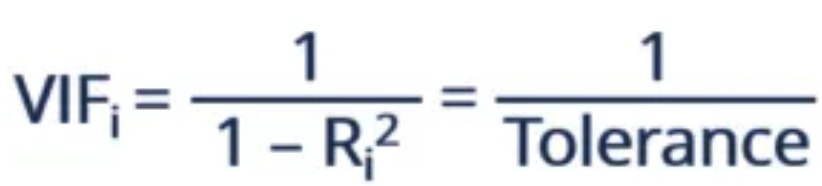

#### Applying VIF for Multicolinearity

In [113]:
vif_data = df[numerical_columns]
total_columns = vif_data.shape[1]
columns_to_be_kept = []
column_index = 0

for i in range (0,total_columns):
    
    vif_value = variance_inflation_factor(vif_data, column_index)
    print (column_index,'---',vif_value)
    
    
    if vif_value <= 6:
        columns_to_be_kept.append( numerical_columns[i] )
        column_index = column_index+1
    
    else:
        vif_data = vif_data.drop([ numerical_columns[i] ] , axis=1)

/Users/sakib/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


0 --- inf


/Users/sakib/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


0 --- inf
0 --- 11.320180023967982
0 --- 8.36369803500036
0 --- 6.5206478777909425
0 --- 5.14950161821261
1 --- 2.611111040579735


/Users/sakib/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


2 --- inf
2 --- 1788.7926256209232
2 --- 8.601028256477212
2 --- 3.832800792153082
3 --- 6.0996533816466405
3 --- 5.581352009642814
4 --- 1.9855843530987702


/Users/sakib/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


5 --- inf
5 --- 4.809538302819332
6 --- 23.270628983464636
6 --- 30.595522588099946
6 --- 4.384346405965575
7 --- 3.0646584155234122
8 --- 2.898639771299225
9 --- 4.377876915347337
10 --- 2.2078535836958486
11 --- 4.916914200506877
12 --- 5.214702030064743
13 --- 3.3861625024231516
14 --- 7.84058330947899
14 --- 5.255034641721459


/Users/sakib/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


15 --- inf
15 --- 7.380634506427207
15 --- 1.421005001517572
16 --- 8.083255010190301
16 --- 1.6241227524040012
17 --- 7.257811920140015
17 --- 15.596243832683006
17 --- 1.825857047132431
18 --- 1.5080839450032724
19 --- 2.1720888348245815
20 --- 2.6233975535272367
21 --- 2.2959970812106216
22 --- 7.360578319196457
22 --- 2.1602387773102514
23 --- 2.8686288267891493
24 --- 6.458218003637239
24 --- 2.847411886563821
25 --- 4.753198156284062
26 --- 16.22735475594819
26 --- 6.424377256363831
26 --- 8.887080381808696
26 --- 2.3804746142952564
27 --- 8.609513476514524
27 --- 13.067550935476769
27 --- 3.500040056654664
28 --- 1.908795587481377
29 --- 17.006562234161628
29 --- 10.73048515371916
29 --- 2.3538497522950457
30 --- 22.104855915136543
30 --- 2.797163963851296
31 --- 3.4241712032177065
32 --- 10.17502145445105
32 --- 6.408710354561287
32 --- 1.0011511962625617
33 --- 3.06919730539727
34 --- 2.8091261600643707
35 --- 20.249538381980678
35 --- 15.864576541593886
35 --- 1.8331649740532

#### Hypothesis Testing- Anova

In [114]:
from scipy.stats import f_oneway

columns_to_be_kept_numerical = []

for i in columns_to_be_kept:
    a = list(df[i])  
    b = list(df['Approved_Flag'])  
    
    group_P1 = [value for value, group in zip(a, b) if group == 'P1']
    group_P2 = [value for value, group in zip(a, b) if group == 'P2']
    group_P3 = [value for value, group in zip(a, b) if group == 'P3']
    group_P4 = [value for value, group in zip(a, b) if group == 'P4']


    f_statistic, p_value = f_oneway(group_P1, group_P2, group_P3, group_P4)

    if p_value <= 0.05:
        columns_to_be_kept_numerical.append(i)

In [115]:
print(columns_to_be_kept_numerical)

['pct_tl_open_L6M', 'pct_tl_closed_L6M', 'Tot_TL_closed_L12M', 'pct_tl_closed_L12M', 'Tot_Missed_Pmnt', 'CC_TL', 'Home_TL', 'PL_TL', 'Secured_TL', 'Unsecured_TL', 'Other_TL', 'Age_Oldest_TL', 'Age_Newest_TL', 'time_since_recent_payment', 'max_recent_level_of_deliq', 'num_deliq_6_12mts', 'num_times_60p_dpd', 'num_std_12mts', 'num_sub', 'num_sub_6mts', 'num_sub_12mts', 'num_dbt', 'num_dbt_12mts', 'num_lss', 'recent_level_of_deliq', 'CC_enq_L12m', 'PL_enq_L12m', 'time_since_recent_enq', 'enq_L3m', 'NETMONTHLYINCOME', 'Time_With_Curr_Empr', 'CC_Flag', 'PL_Flag', 'pct_PL_enq_L6m_of_ever', 'pct_CC_enq_L6m_of_ever', 'HL_Flag', 'GL_Flag']


#### Features Selection

In [116]:
# listing all the final features
features = columns_to_be_kept_numerical + ['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2', 'first_prod_enq2']
df = df[features + ['Approved_Flag']]

In [117]:
df.head()

,pct_tl_open_L6M,pct_tl_closed_L6M,Tot_TL_closed_L12M,pct_tl_closed_L12M,Tot_Missed_Pmnt,CC_TL,Home_TL,PL_TL,Secured_TL,Unsecured_TL,...,pct_PL_enq_L6m_of_ever,pct_CC_enq_L6m_of_ever,HL_Flag,GL_Flag,MARITALSTATUS,EDUCATION,GENDER,last_prod_enq2,first_prod_enq2,Approved_Flag
0,0.000,0.0,0,0.000,0,0,0,4,1,4,...,0.000,0.0,1,0,Married,12TH,M,PL,PL,P2
1,0.000,0.0,0,0.000,0,0,0,0,0,1,...,0.000,0.0,0,0,Single,GRADUATE,F,ConsumerLoan,ConsumerLoan,P2
2,0.125,0.0,0,0.000,1,0,0,0,2,6,...,0.000,0.0,1,0,Married,SSC,M,ConsumerLoan,others,P2
3,0.000,0.0,0,0.000,0,0,0,0,3,0,...,0.000,0.0,0,0,Married,POST-GRADUATE,M,AL,AL,P1
4,0.000,0.0,1,0.167,0,0,0,0,6,0,...,0.429,0.0,1,0,Married,12TH,M,ConsumerLoan,PL,P3


#### Label encoding

In [118]:
df['MARITALSTATUS'].unique()    

array(['Married', 'Single'], dtype=object)

In [119]:
df['GENDER'].unique()

array(['M', 'F'], dtype=object)

In [120]:
df['last_prod_enq2'].unique()

array(['PL', 'ConsumerLoan', 'AL', 'CC', 'others', 'HL'], dtype=object)

In [121]:
df['first_prod_enq2'].unique()

array(['PL', 'ConsumerLoan', 'others', 'AL', 'HL', 'CC'], dtype=object)

In [122]:
df['EDUCATION'].unique()

array(['12TH', 'GRADUATE', 'SSC', 'POST-GRADUATE', 'UNDER GRADUATE',
       'OTHERS', 'PROFESSIONAL'], dtype=object)

In [123]:
education_mapping = {
    'SSC': 1,
    '12TH': 2,
    'GRADUATE': 3,
    'UNDER GRADUATE': 3,
    'POST-GRADUATE': 4,
    'OTHERS': 1,
    'PROFESSIONAL': 3
}

df['EDUCATION'] = df['EDUCATION'].replace(education_mapping)

In [124]:
df['EDUCATION'].value_counts()

EDUCATION
3    18931
2    11703
1     9532
4     1898
Name: count, dtype: int64

#### One-hot encoding

In [125]:
df_encoded = pd.get_dummies(df, columns=['MARITALSTATUS','GENDER', 'last_prod_enq2' ,'first_prod_enq2'])

In [126]:
df_encoded.head()

,pct_tl_open_L6M,pct_tl_closed_L6M,Tot_TL_closed_L12M,pct_tl_closed_L12M,Tot_Missed_Pmnt,CC_TL,Home_TL,PL_TL,Secured_TL,Unsecured_TL,...,last_prod_enq2_ConsumerLoan,last_prod_enq2_HL,last_prod_enq2_PL,last_prod_enq2_others,first_prod_enq2_AL,first_prod_enq2_CC,first_prod_enq2_ConsumerLoan,first_prod_enq2_HL,first_prod_enq2_PL,first_prod_enq2_others
0,0.000,0.0,0,0.000,0,0,0,4,1,4,...,False,False,True,False,False,False,False,False,True,False
1,0.000,0.0,0,0.000,0,0,0,0,0,1,...,True,False,False,False,False,False,True,False,False,False
2,0.125,0.0,0,0.000,1,0,0,0,2,6,...,True,False,False,False,False,False,False,False,False,True
3,0.000,0.0,0,0.000,0,0,0,0,3,0,...,False,False,False,False,True,False,False,False,False,False
4,0.000,0.0,1,0.167,0,0,0,0,6,0,...,True,False,False,False,False,False,False,False,True,False


#### Features Separating

In [127]:
X = df_encoded.drop(["Approved_Flag"], axis=1)
y = df_encoded["Approved_Flag"]

#### Featues Scaling

In [157]:
from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(X)

#### Label Encoding

In [158]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

#### Train Test Split

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size = 0.2, random_state = 42)

### Building Machine Learning Models for Credit Risk

### Random Forest

In [160]:
rf_clf = RandomForestClassifier(n_estimators = 200, random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [161]:
y_pred = rf_clf.predict(X_test)

In [162]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.71      0.77      1014
           1       0.80      0.93      0.86      5045
           2       0.45      0.22      0.29      1325
           3       0.73      0.73      0.73      1029

    accuracy                           0.77      8413
   macro avg       0.70      0.65      0.66      8413
weighted avg       0.74      0.77      0.74      8413



### XGBoost

In [163]:
import xgboost as xgb

xgb_classifier = xgb.XGBClassifier(n_estimators=200, max_depth=16)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=16, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [164]:
y_pred = xgb_classifier.predict(X_test)

In [165]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1014
           1       0.82      0.90      0.86      5045
           2       0.43      0.28      0.34      1325
           3       0.71      0.72      0.72      1029

    accuracy                           0.77      8413
   macro avg       0.69      0.67      0.68      8413
weighted avg       0.75      0.77      0.75      8413



### LGBMClassifier

In [166]:
from lightgbm import LGBMClassifier
lgbm_classifier = LGBMClassifier(colsample_bytree= 0.9, max_depth=20, num_leaves=16, n_estimators=200)

In [167]:
lgbm_classifier.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3027
[LightGBM] [Info] Number of data points in the train set: 33651, number of used features: 54
[LightGBM] [Info] Start training from score -2.156606
[LightGBM] [Info] Start training from score -0.500165
[LightGBM] [Info] Start training from score -1.883865
[LightGBM] [Info] Start training from score -2.072659


LGBMClassifier(colsample_bytree=0.9, max_depth=20, n_estimators=200,
               num_leaves=16)

In [168]:
y_pred = lgbm_classifier.predict(X_test)

In [169]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.76      0.80      1014
           1       0.82      0.92      0.87      5045
           2       0.47      0.29      0.36      1325
           3       0.74      0.75      0.75      1029

    accuracy                           0.78      8413
   macro avg       0.72      0.68      0.69      8413
weighted avg       0.76      0.78      0.77      8413



### Neural Network

In [182]:
from sklearn.neural_network import MLPClassifier

neural_classifier = MLPClassifier(hidden_layer_sizes=(128,64,32),activation='relu', solver='lbfgs',max_iter=500, learning_rate_init=0.002,  early_stopping=True)

In [183]:
neural_classifier.fit(X_train, y_train)
y_pred = neural_classifier.predict(X_test)

In [184]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1014
           1       0.83      0.90      0.86      5045
           2       0.45      0.33      0.38      1325
           3       0.73      0.70      0.71      1029

    accuracy                           0.77      8413
   macro avg       0.71      0.68      0.69      8413
weighted avg       0.76      0.77      0.76      8413

